##Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IP/HW3/HW3Model3/datasetmodel3
import cv2
import cv2 as cv
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras.utils as image
import random
import math
import shutil
import pathlib
from pathlib import Path
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
from sklearn.metrics import confusion_matrix,precision_score,recall_score,ConfusionMatrixDisplay,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Flatten,Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Conv2D, ZeroPadding2D,MaxPooling2D,Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.optimizers import Adam,SGD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/IP/HW3/HW3Model3/datasetmodel3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
data = []
images_dir = '/content/drive/MyDrive/IP/HW3/HW3Model3/datasetmodel3'
for filename in os.listdir(images_dir):
    if filename.endswith(".tif"):
        img_path = os.path.join(images_dir, filename)
        img_id = filename.split('_')[0][2:]
        label = int(filename.split('_')[1].split('.')[0])
        data.append((img_path, label))

D_F = pd.DataFrame(data, columns=['image', 'label'])
print(D_F)


                                                 image  label
0    /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      0
1    /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      0
2    /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      0
3    /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      0
4    /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      0
..                                                 ...    ...
255  /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      1
256  /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      1
257  /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      1
258  /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      1
259  /content/drive/MyDrive/IP/HW3/HW3Model3/datase...      1

[260 rows x 2 columns]


In [ ]:
def data_preprocessing(dataframe, dim):
    n = dataframe.shape[0]
    images = np.zeros((n, dim, dim, 3), dtype=np.float32)
    labels = np.zeros((n, 2), dtype=np.float32)

    for i, (_, row) in enumerate(dataframe.iterrows()):
        img = cv2.imread(str(row['image']))
        img = cv2.resize(img, (dim, dim))
        encoded_label = np_utils.to_categorical(row['label'], num_classes=2)
        orig_img = img.astype(np.float32) / 255.
        images[i] = orig_img
        labels[i] = encoded_label

    return images, labels

dim = 257
images, labels = data_preprocessing(D_F, dim)
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Images shape: (260, 257, 257, 3)
Labels shape: (260, 2)


##Seperate 60% of the dataset for training , 20% for test and 20% for validation

In [ ]:
seed = 369
np.random.seed(seed)

In [ ]:
# Splitting the data into train, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

x , y = images, labels

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_ratio, stratify=y, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=val_ratio/(train_ratio+val_ratio),
                                                  stratify=y_train_val, random_state=seed)

# Printing the shapes of the train, validation, and test sets
print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (156, 257, 257, 3)
y_train shape: (156, 2)
X_val shape: (52, 257, 257, 3)
y_val shape: (52, 2)
X_test shape: (52, 257, 257, 3)
y_test shape: (52, 2)


##Create artificial images with data augmentation and add them to our dataset

In [ ]:
Batch_S = 100
N_epochs = 500
LR = 0.0001

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

training_data = datagen.flow(x_train, y_train, batch_size=10)

num_train_samples = x_train.shape[0]
total_augmented_images = num_train_samples * 10

print("Total augmented images per original image:", total_augmented_images)

Total augmented images per original image: 1560


In [ ]:
# Number of images in the train, validation, and test sets
print("Train set:")
print("Number of images:", x_train.shape[0])

print("Validation set:")
print("Number of images:", x_val.shape[0])

print("Test set:")
print("Number of images:", x_test.shape[0])

# Total number of augmented images
num_train_samples = x_train.shape[0]
batch_size = Batch_S
total_augmented_images = num_train_samples * 10

print("Total augmented images after augmentation:", total_augmented_images)

# Total number of images after augmentation
total_images = total_augmented_images + x_train.shape[0] + x_val.shape[0] +  x_test.shape[0]
print("Total images after augmentation:", total_images)

Train set:
Number of images: 156
Validation set:
Number of images: 52
Test set:
Number of images: 52
Total augmented images after augmentation: 1560
Total images after augmentation: 1820


##Create a convolutional neural network (CNN3)

In [ ]:
model3 = Sequential()

# Convolutional layers
model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(257, 257, 3)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(2, activation='softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                    

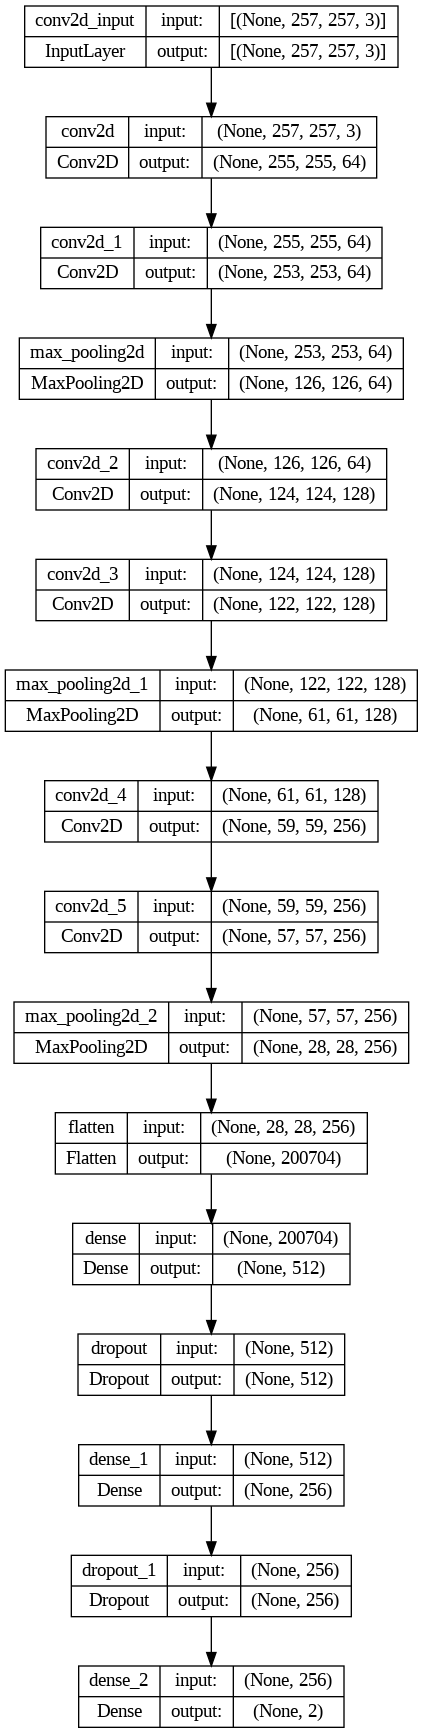

In [ ]:
plot_model(model3, show_shapes=True)

##Training the model3

In [ ]:
optimizer = Adam(learning_rate=LR)
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", monitor = 'val_accuracy',verbose=1, save_weights_only=True)

In [ ]:
history = model3.fit(
    training_data,
    epochs= N_epochs,
    validation_data= (x_val, y_val),
    steps_per_epoch= x_train.shape[0] / Batch_S,
    verbose=1,
    callbacks=[checkpointer])

Epoch 1/500
2/1 [======================================] - ETA: 0s - loss: 0.6944 - accuracy: 0.5000
Epoch 1: saving model to best_weights.hdf5
1/1 [==============================] - 29s 22s/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/500
2/1 [======================================] - ETA: 0s - loss: 0.6926 - accuracy: 0.6000
Epoch 2: saving model to best_weights.hdf5
1/1 [==============================] - 3s 4s/step - loss: 0.6926 - accuracy: 0.6000 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/500
2/1 [======================================] - ETA: 0s - loss: 0.7429 - accuracy: 0.3000
Epoch 3: saving model to best_weights.hdf5
1/1 [==============================] - 2s 4s/step - loss: 0.7429 - accuracy: 0.3000 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 4/500
2/1 [======================================] - ETA: 0s - loss: 0.7368 - accuracy: 0.3500
Epoch 4: saving model to best_weights.hdf5
1/1 [==============================] - 4s 7s

In [ ]:
model3.save_weights("model_weights_hist.h5")
model3.save("model_hist.h5")

##Display variation of each epoch in training accuracy and loss function

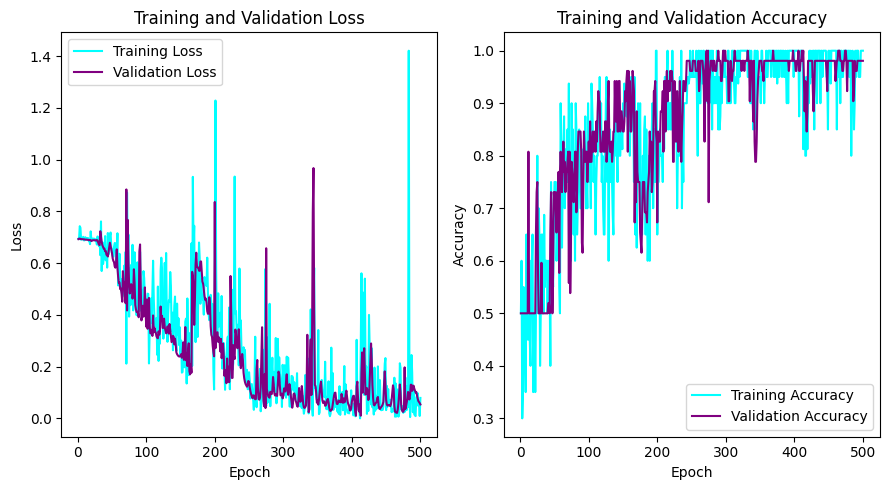

In [ ]:
# Extract the training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(9, 5))

# Plot the training and validation loss
axs[0].plot(range(1, N_epochs + 1), training_loss, label='Training Loss', color='cyan')
axs[0].plot(range(1, N_epochs + 1), validation_loss, label='Validation Loss', color='purple')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the training and validation accuracy
axs[1].plot(range(1, N_epochs + 1), training_accuracy, label='Training Accuracy', color='cyan')
axs[1].plot(range(1, N_epochs + 1), validation_accuracy, label='Validation Accuracy', color='purple')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()
# Show the figure
plt.show()

##Display model3 performance metrics

2/2 [==============================] - 0s 103ms/step
Test Loss: 0.02549276128411293
Test Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        26

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

Confusion Matrix:
[[26  0]
 [ 0 26]]
Test Specificity: 1.0


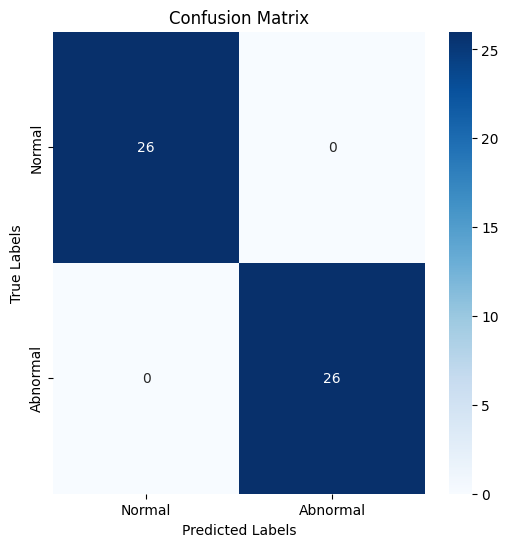

In [ ]:
# Convert true labels to binary format
y_test_binary = np.argmax(y_test, axis=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(x_test, y_test, verbose=0)

# Predict the labels for the test set
y_pred_classes = np.argmax(model3.predict(x_test), axis=1)

# Compute model performance metrics
classification_rep = classification_report(y_test_binary, y_pred_classes)
confusion_mat = confusion_matrix(y_test_binary, y_pred_classes)
true_negative, false_positive, _, _ = confusion_mat.ravel()
specificity = true_negative / (true_negative + false_positive)

# Print model performance metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(confusion_mat)
print("Test Specificity:", specificity)

# Define the class labels
class_labels = ['Normal', 'Abnormal']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()
